<a href="https://colab.research.google.com/github/adrianfr10/forecasting-analysis-semantics-assignments/blob/master/Task_1_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

LOADING DATA

In [22]:
order_items = pd.read_csv('order_items.csv', parse_dates=['shipping_limit_date'])
print(order_items.head())

                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  
0 2017-09-19 09:45:35   58.90          13.29  
1 2017-05-03 11:05:13  239.90          19.93  
2 2018-01-18 14:48:30  199.00          17.87  
3 2018-08-15 10:10:18   12.99          12.79  
4

AGGREGATING DATA

In [23]:
daily_sales = order_items.groupby(order_items['shipping_limit_date'].dt.date).agg({'product_id': 'count'}).rename(columns={'product_id': 'sales'})
daily_sales.tail()

,sales
shipping_limit_date,
2018-09-14,2
2018-09-18,1
2020-02-03,1
2020-02-05,1
2020-04-09,2


DATA VISUALIZATION


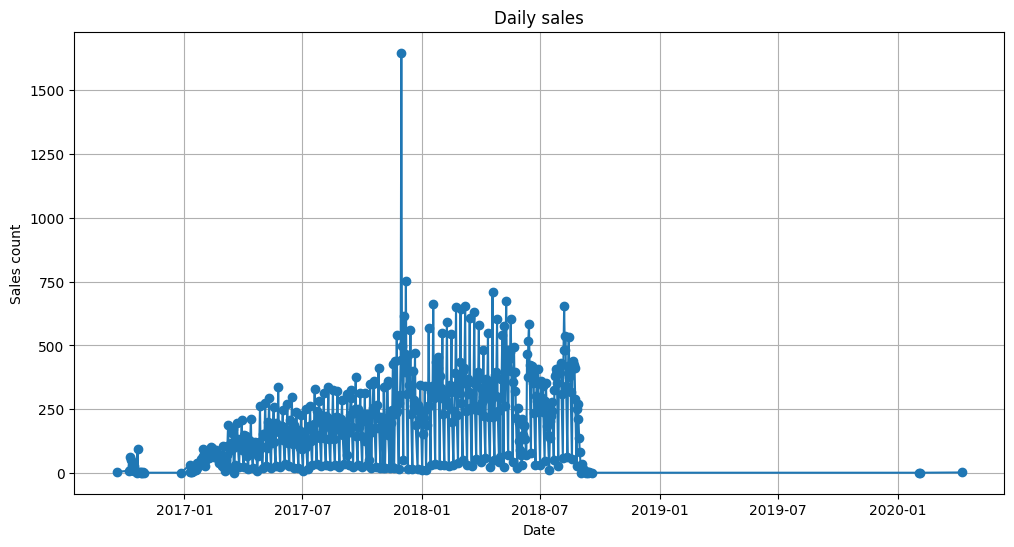

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['sales'], marker='o')
plt.title('Daily sales')
plt.xlabel('Date')
plt.ylabel('Sales count')
plt.grid(True)
plt.show()

The ARIMA (AutoRegressive Integrated Moving Average) model is a powerful statistical tool for analyzing and forecasting time series data. It effectively handles common patterns in time series, making it a robust method for generating accurate forecasts.

The ARIMA model is denoted as ARIMA(p, d, q), where:
* p: Number of lag observations.
* d: Degree of differencing applied.
* q: Size of the moving average window.

These parameters can be set to zero, allowing the ARIMA model to function as simpler models like ARMA, AR, or MA.

The model assumes the time series data is generated by an ARIMA process, emphasizing the importance of verifying this assumption in both the raw data and the residuals of the model's forecasts.

BUILDING ARIMA MODEL

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

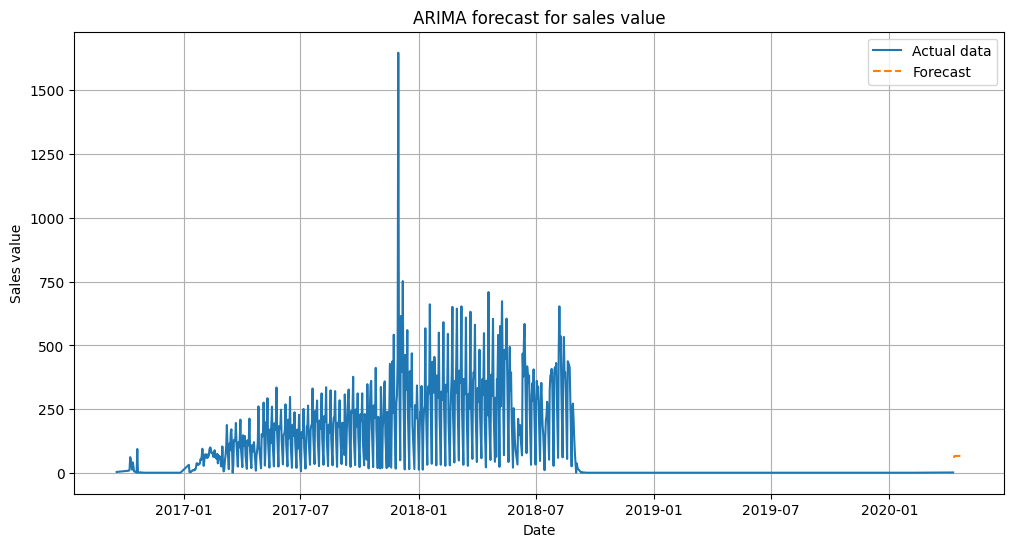

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Creating ARIMA model
model = ARIMA(daily_sales['sales'], order=(1, 1, 1))
fitted_model = model.fit()

# Forecasting
forecast = fitted_model.forecast(steps=14)

# Forecast visualization
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['sales'], label='Actual data')
plt.plot(pd.date_range(start=daily_sales.index[-1], periods=15, inclusive='right'), forecast, label='Forecast', linestyle='--')
plt.title('ARIMA forecast for sales value')
plt.xlabel('Date')
plt.ylabel('Sales value')
plt.legend()
plt.grid(True)
plt.show()

 SUMMARY: ARIMA (AutoRegressive Integrated Moving Average) models are commonly used for time series forecasting, including forecasting product demand. However, the appropriateness of using ARIMA models depends on several factors, but mainly stationarity of the data, data quality, selection of the right ARIMA model and its assumptions. In this analysis it seems highly appropirate to use this kind of time series forecasting, however it is not the only suitable method since for example SARIMA models on top of ARIMA functionality, search for seasonal patterns in the data so it can be even more accurate.

PERFORMING REGRESSION WITH XGBOOST REGRESSOR

## XGBoost
XGBoost (Extreme Gradient Boosting) Regressor is a powerful machine learning algorithm designed for supervised learning tasks, especially regression and classification. It is based on the gradient boosting framework and is known for its efficiency, flexibility, and high performance.

XGBoost builds an ensemble of decision trees sequentially. Each new tree corrects errors made by the previous ones, resulting in a robust model that can handle complex patterns in the data.

It uses gradient descent to minimize the loss function, which measures how well the model's predictions match the actual data. This optimization ensures that each tree added to the model improves its accuracy.

The advantages of this regressor are: robustness, flexibility and high performance, however, it is quite complex and is computationally heavy in terms of using resources.

It has a broad application potential in finance, engineering, healthcare or marketing. That's why I'm going to use it for this problem.

In [28]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

daily_sales.rename(columns={'sales': 'Sales value'}, inplace=True)
daily_sales.index = pd.to_datetime(daily_sales.index, errors='coerce')
# Creating train and test sets
split_date = np.datetime64('2020-02-03')
train = daily_sales.loc[daily_sales.index <= split_date].copy()
test = daily_sales.loc[daily_sales.index > split_date].copy()

def create_features(df, label=None):
  """
  Creates time series features from datetime index
  """
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day

  X = df[['hour','dayofweek','quarter','month','year',
          'dayofyear','dayofmonth']]
  if label:
      y = df[label]
      return X, y
  return X

X_train, y_train = create_features(train, label="Sales value")
X_test, y_test = create_features(test, label="Sales value")

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

FORECAST ON TEST SET

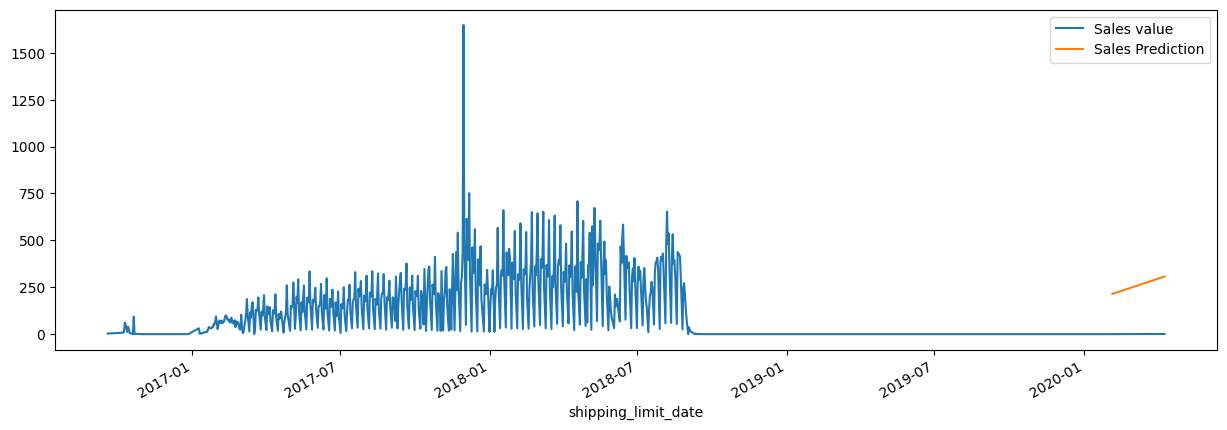

In [29]:
test['Sales Prediction'] = reg.predict(X_test)
all = pd.concat([test, train], sort=False)
_ = all[['Sales value','Sales Prediction']].plot(figsize=(15, 5))


FORECAST

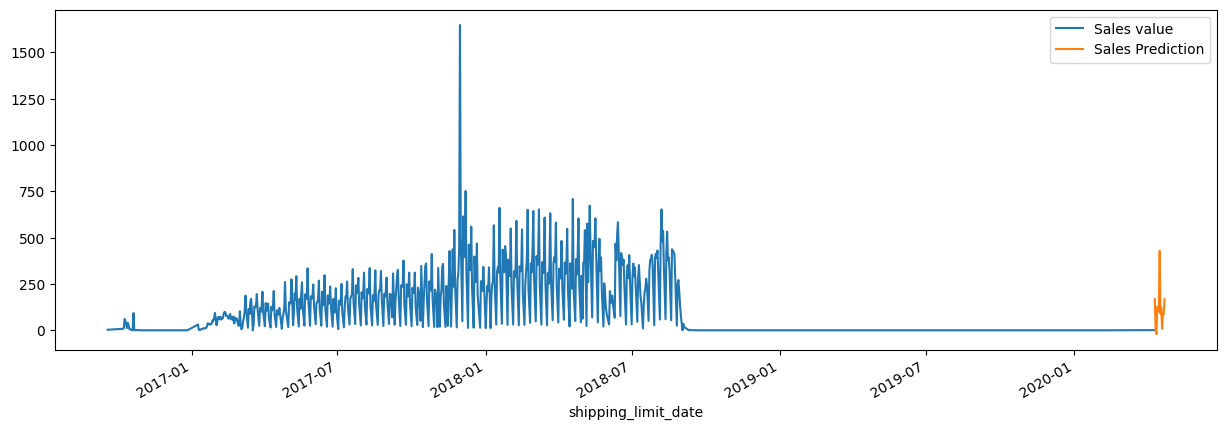

In [30]:
last_date = daily_sales.index.max()
future_dates = pd.date_range(last_date, periods=14, freq='D')[1:]

# Create an extended DataFrame for forecasting
forecast_df = pd.DataFrame(index=future_dates)
forecast_df.index.name = 'shipping_limit_date'
# Concatenate the original DataFrame and the forecast DataFrame
extended_daily_sales = pd.concat([daily_sales, forecast_df])

# Create features for the extended period
features = create_features(extended_daily_sales)

# Split the result into X_extended
X_extended = features

# Extract the part of X_extended corresponding to the forecast period
X_forecast = X_extended.tail(13)  # Assuming you're predicting for the next 6 days

# Train the XGBoost model (assuming 'reg' is already trained as in your code)
reg.fit(X_train, y_train)

# Make predictions for the forecast period
forecast_values = reg.predict(X_forecast)

# Add the forecasted values to the extended DataFrame
forecast_df['Sales Prediction'] = forecast_values

# Plotting
all_data = pd.concat([daily_sales, forecast_df], sort=False)
_ = all_data[['Sales value', 'Sales Prediction']].plot(figsize=(15, 5))

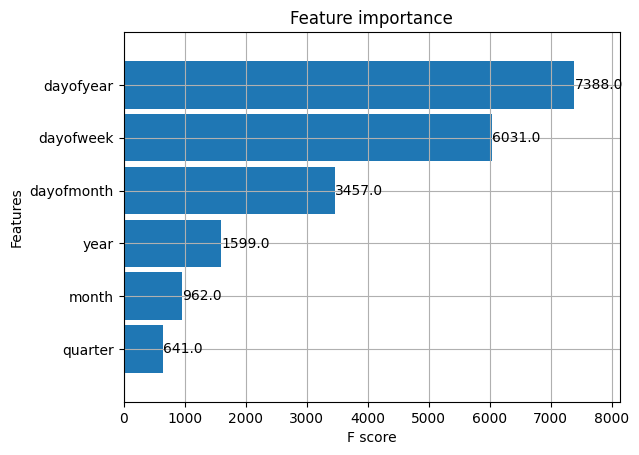

In [31]:
from xgboost import plot_importance
_ = plot_importance(reg, height=0.9)


CONCLUSION: Time series and regression are both methods of predictive analytics, but they have different assumptions, techniques, and applications. Time series assumes that the data is ordered and dependent on time, while regression assumes that the data is independent and random. Time series uses methods such as smoothing, decomposition, autocorrelation, and ARIMA models, while regression uses methods such as linear, logistic, polynomial, and multivariate models. Time series is more suitable for forecasting and detecting patterns in temporal data, while regression is more suitable for estimating and explaining the effect of variables on an outcome.